首先，导入相关的模块。

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

从正态分布，随机生成两组一维数据，正态分布的期望和方差如代码所示：

In [2]:
np.random.seed(1111)

mu1, mu2 = 1, 3
sigma1, sigma2 = 0.7, 0.4
num1, num2 = 20, 20

data1 = np.random.randn(num1) * sigma1 + mu1
data2 = np.random.randn(num2) * sigma2 + mu2

print('cluster 1 with mean {} std {}'.format(mu1, sigma1))
print('cluster 2 with mean {} std {}'.format(mu2, sigma2))

cluster 1 with mean 1 std 0.7
cluster 2 with mean 3 std 0.4


生成的数据图示如下：

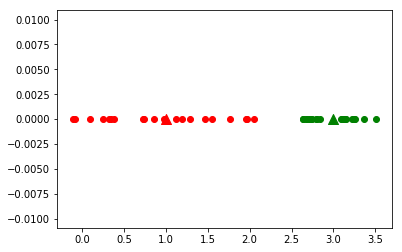

In [3]:
def plot(y, **kwargs):
    plt.scatter(y, np.zeros_like(y), **kwargs)

plot(data1, c='r')
plt.scatter(mu1, 0, c='r', s=100, marker='^')
plot(data2, c='g')
plt.scatter(mu2, 0, c='g', s=100, marker='^')


许多场景下，我们提前不知道数据是如何生成的，即数据没有标注：

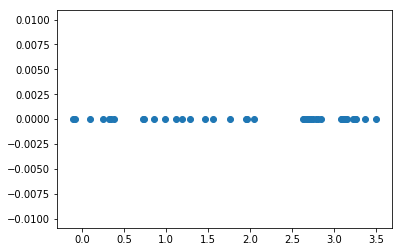

In [4]:
data = np.concatenate([data1, data2])
plot(data)

K-Means 聚类是一个迭代算法。给定目标聚类数目 K,算法流程如下：
1. 初始化 K 个中心点。
2. 对每个中心点 $c_i$，计算各个数据点 $x_j$ 到此中心点的距离 $dist_{ij}$（e.g. 欧式距离）。
3. 对每个数据点，将其归为距离最近的中心。
4. 对每个中心点 $c_i$，利用其下的数据点，重新估计值 $c_i = \sum_{x_j \in c_i} x_j$。
5. 重复 2 ~ 4，至于满足终止条件。

Iter 0, total dist 8.13307100934
Iter 1, total dist 5.06138695227
Iter 2, total dist 5.06138695227
Iter 3, total dist 5.06138695227
Iter 4, total dist 5.06138695227
Iter 5, total dist 5.06138695227
Iter 6, total dist 5.06138695227
Iter 7, total dist 5.06138695227
Iter 8, total dist 5.06138695227
Iter 9, total dist 5.06138695227
Estimated Center 1 - val: 0.70
Estimated Center 2 - val: 2.80


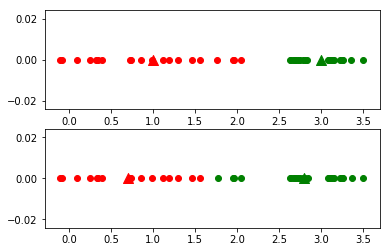

In [5]:
def kmeans(x, nb_class=2, max_iter=10, verbose=False):
    # random initiailize centers, step 1
    means = x[np.random.choice(range(len(x)), nb_class, replace=False)]
    
    dist = np.zeros([nb_class, len(x)])
    for i in range(max_iter):
        # calculate distance, step 2
        for j in range(nb_class):
            for k, point in enumerate(x):
                dist[j][k] = (means[j] - point) ** 2 
                
        # update means, step 3 & 4
        min_idx = np.argmin(dist, 0)
        for j in range(nb_class):
            ele = [x[k] for k, idx in enumerate(min_idx) if idx == j]
            means[j] = np.mean(ele)
            
        # calculate total distance for early stop
        total_dist = 0
        for j in range(nb_class):
            total_dist = sum([(means[j] - x[k]) ** 2 for k, idx in enumerate(min_idx) if idx == j])   
        if verbose:
            print("Iter {}, total dist {}".format(i, total_dist)) 
    
    for j in range(nb_class):
            for k, point in enumerate(x):
                dist[j][k] = (means[j] - point) ** 2 
    min_idx = np.argmin(dist, 0)
    clusters = []
    for i in range(nb_class):
        ele = [x[k] for k, idx in enumerate(min_idx) if idx == i]
        clusters.append(np.asarray(ele))
    
    return means, clusters

# original clusters
plt.subplot(2, 1, 1)
plot(data1, c='r')
plt.scatter(mu1, 0, c='r', s=100, marker='^')

plot(data2, c='g')
plt.scatter(mu2, 0, c='g', s=100, marker='^')

# k-mean clusters
centers, clusters = kmeans(data, max_iter=10, verbose=True)
print('Estimated Center 1 - val: {:.2f}'.format(centers[0]))
print('Estimated Center 2 - val: {:.2f}'.format(centers[1]))

plt.subplot(2, 1, 2)
plot(clusters[0], c='r')
plt.scatter(centers[0], 0, c='r', s=100, marker='^')

plot(clusters[1], c='g')
plt.scatter(centers[1], 0, c='g', s=100, marker='^')

kmeans 算法对初始值非常敏感。这里我们随机挑选两个数据点做为中心点的初始值。实际中可能需要更鲁棒初始化方法，此处不再展开。

kmeans 采用的是硬件判决，即距离哪个中心点的距离最近，分配给谁。在上面的示例，两类重合的点，被错误归为了另一类。缺乏置信度。下面介绍本文的主题——高斯混合模型（GMM）。GMM 采用的是软判决的方式来进行聚类。

GMM 假设数据服从如下公布：
$$
p(x) = \sum_i^n \pi_i \cdot g_i(x)
$$

其中，$g_i = N(\mu_i, \sigma_i)$，且 $\sum_i^n \pi_i = 1$。

在我们例子中，$\mu_1 = 1$， $\mu_2 = 3$ $\sigma_1 = \sigma_2 = 1$ $\pi_1 = \pi_2 = 0.5$。当然，实际中，我们是往往不知道其真实分布，但 GMM 有很强的建模能力，能够对许多实际问题进行良好的近似建模。

GMM 一般用 EM（期望-最大化算法）来优化。给定目标聚类数目 K,算法流程如下：

1. 初始化 K 个高斯的参数 $\mu_i$, $\sigma_i$, $\pi_i$, $i=1,\dots, K$。

2. （期望）：对每个高斯 $g_i$，对每个数据点 $x_i$，计算 $\gamma_{ij} = \frac{\pi_i \cdot g_i(x_j)}{\sum_{k-1}^K \pi_k \cdot g_k(x_j) }$。

3. （最大化）：对每个高斯 $g_i$，重新估计其参数 $\hat{\mu}_i = \frac{\sum_{j=1}^N \gamma_{ij} \cdot x_j}{ \sum_{j=1}^N \gamma_{ij} }$, $\hat{\sigma}_i = \frac{\sum_{j=1}^N \gamma_{ij} \cdot (x_j - \hat{\mu}_i)^2}{ \sum_{j=1}^N \gamma_{ij} }$, $ \hat{\pi}_i = \frac{\sum_{j=1}^N \gamma_{ij}}{N} = \frac{\sum_{j=1}^N \gamma_{ij}}{\sum_{j=1}^N \sum_{i=1}^K  \gamma_{ij}} $。
4. 重复 2 ~ 3，至于满足终止条件。

GMM 的 EM 训练中，不同于 kmeans 步骤 2、3 的硬件分配，步骤 2 计算每个数据点的“归属度”，软性的更新参数（步骤3）。

GMM 对初始值敏感。一般先用kmean方法聚类，利用聚类数据点的均值和（协）方差作为各个高斯分量的初始值。

Iter 0, log likelihood -52.2221578339
Iter 1, log likelihood -51.7372519942
Iter 2, log likelihood -51.1416631328
Iter 3, log likelihood -50.5280229913
Iter 4, log likelihood -50.189923029
Iter 5, log likelihood -50.1243246025
Iter 6, log likelihood -50.1175371708
Estimated Gaussian 1 - mu: 2.97, sigma: 0.27, pi: 0.49
Estimated Gaussian 2 - mu: 0.97, sigma: 0.72, pi: 0.51


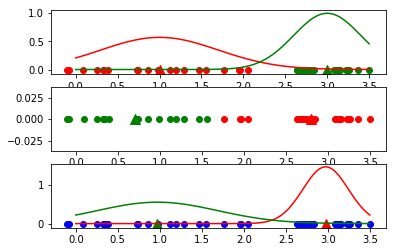

In [6]:
def norm_dist(x, mu, sigma):
    return np.exp(-(x - mu) ** 2 / 2 / sigma ** 2) / ((2 * np.pi) ** 0.5 * sigma)


def gmm(x, nb_class=2, max_iter=100, threshold=1):
    # initialize using kmeans clustering
    mus, clusters = kmeans(x, 2)
    sigmas = np.zeros(nb_class)
    for i in range(nb_class):
        sigmas[i] = np.std(clusters[i])
    pis = np.asarray([len(cluster) / float(len(x)) for cluster in clusters])
    
    gammas = np.zeros([nb_class, len(x)])
    cur_lld = -np.float('inf')
    for i in range(max_iter):
        # calculate probability， step 2
        for j in range(nb_class):
            for k, point in enumerate(x):
                gammas[j][k] =  norm_dist(point, mus[j], sigmas[j]) * pis[j]
        gammas = gammas / np.sum(gammas, 0)
        
        # update estimation, step 3
        for j in range(nb_class):
            total, total_squared, norm_factor = 0, 0, 0
            # mu
            for k in range(len(x)):
                total += x[k] * gammas[j][k]
                norm_factor += gammas[j][k]
            mus[j] = total / norm_factor
            
            # sigma
            for k in range(len(x)):
                total_squared += (x[k] - mus[j]) ** 2 * gammas[j][k]
            sigmas[j] = (total_squared / norm_factor) ** 0.5
            
            # pi
            pis[j] = norm_factor / len(x)
            
            
        # likelihood
        lld = 0
        for e in x:
            ld = 0
            for j in range(nb_class):
                ld += norm_dist(e, mus[j], sigmas[j]) * pis[j]
            lld += np.log(ld)
        cur_lld, last_lld = lld, cur_lld
    
        print("Iter {}, log likelihood {}".format(i, lld)) 
        if cur_lld - last_lld <= threshold:
            break
            
    return mus, sigmas, pis

# original clusters
plt.subplot(3, 1, 1)
plot(data1, c='r')
plt.scatter(mu1, 0, c='r', s=100, marker='^')

plot(data2, c='g')
plt.scatter(mu2, 0, c='g', s=100, marker='^')


x1 = np.linspace(0, 3.5, 100)
plt.plot(x1, norm_dist(x1, mu1, sigma1), c='r')
x2 = np.linspace(0, 3.5, 100)
plt.plot(x2, norm_dist(x2, mu2, sigma2), c='g')

# k-mean clusters
centers, clusters = kmeans(data)
plt.subplot(3, 1, 2)
plot(clusters[0], c='r')
plt.scatter(centers[0], 0, c='r', s=100, marker='^')

plot(clusters[1], c='g')
plt.scatter(centers[1], 0, c='g', s=100, marker='^')


# gmm
mus, sigmas, pis = gmm(data, threshold=0.05)
print('Estimated Gaussian 1 - mu: {:.2f}, sigma: {:.2f}, pi: {:.2f}'.format(mus[0], sigmas[0], pis[0]))
print('Estimated Gaussian 2 - mu: {:.2f}, sigma: {:.2f}, pi: {:.2f}'.format(mus[1], sigmas[1], pis[1]))


plt.subplot(3, 1, 3)
plot(data, c='b')
plt.scatter(mus[0], 0, c='r', s=100, marker='^')
plt.scatter(mus[1], 0, c='g', s=100, marker='^')

x1 = np.linspace(0, 3.5, 100)
plt.plot(x1, norm_dist(x1, mus[0], sigmas[0]), c='r')
x2 = np.linspace(0, 3.5, 100)
plt.plot(x2, norm_dist(x2, mus[1], sigmas[1]), c='g')
    